## 1. Понимание бизнеса

#### 1.1 Цель
Определить качество вина по его характеристикам.

#### 1.2 Описание
Датасет содержит данные о красном и белом португальском вине "Vinho Verde" и его характеристиках.

Датасет может быть использоваться для задач классификации и регрессии. Классы упорядочены и несбалансированы
 (т.е. нормальных вин значительно больше, чем отличных или плохих).

## 2. Понимание данных

#### 2.1. Импорт библиотек

In [1]:
# Ignore warnings
import warnings
warnings.filterwarnings('ignore')

# Handle table-like data and matrices
import numpy as np
import pandas as pd

# Modelling Algorithms
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC, LinearSVC
from sklearn.ensemble import RandomForestClassifier , GradientBoostingClassifier

# Modelling Helpers
from sklearn.impute import SimpleImputer as Imputer
from sklearn.preprocessing import  Normalizer , scale
from sklearn.model_selection import train_test_split , StratifiedKFold
from sklearn.feature_selection import RFECV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix

# Visualisation
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.pylab as pylab
import seaborn as sns

# Some additionals
import os.path
import pickle

# Configure visualisations
%matplotlib inline
mpl.style.use('ggplot')
sns.set_style('white')
pylab.rcParams[ 'figure.figsize' ] = 8 , 6

#### 2.2 Вспомогательные функции

In [2]:
def plot_distribution(df , var , target , **kwargs):
    '''Визуализирует плотности распределения'''
    row = kwargs.get('row' , None)
    col = kwargs.get('col' , None)
    offset = (df[ var ].max() - df[ var ].min()) * 0.1
    xleft = kwargs.get('xleft' , df[ var ].min() - offset)
    xright = kwargs.get('xright' , df[ var ].max() + offset)
    facet = sns.FacetGrid(df , hue=target , aspect=4 , row = row , col = col)
    facet.map(sns.kdeplot , var , shade= True)
    facet.set(xlim=(xleft, xright))
    facet.add_legend()

def plot_correlation_map(df):
    '''Визуализирует матрицу корреляций'''
    corr = df.corr()
    _ , ax = plt.subplots(figsize =(12 , 10))
    cmap = sns.diverging_palette(220 , 10 , as_cmap = True)
    _ = sns.heatmap(
        corr, 
        cmap = cmap,
        square=True, 
        cbar_kws={ 'shrink' : .9 }, 
        ax=ax, 
        annot = True, 
        annot_kws = { 'fontsize' : 12 }
   )
    
def plot_model_var_imp(model , X , y, index = None):
    '''Визуализирует важность признаков'''
    if index is None:
        index = X.columns
    
    imp = pd.DataFrame(
        model.feature_importances_  , 
        columns = [ 'Importance' ] , 
        index = index 
   )
    imp = imp.sort_values([ 'Importance' ] , ascending = True)
    imp.plot(kind = 'barh')
    
def replace_nones(df, name):
    '''Заменяет пропущенные значения средними'''
    df[name] = df[name].fillna(df[name].mean())
    

#### 2.3 Загрузка данных

In [3]:
df = pd.read_csv('../data/raw/winequalityN.csv')

#### 2.4 Статистика и визуализации

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6497 entries, 0 to 6496
Data columns (total 13 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   type                  6497 non-null   object 
 1   fixed acidity         6487 non-null   float64
 2   volatile acidity      6489 non-null   float64
 3   citric acid           6494 non-null   float64
 4   residual sugar        6495 non-null   float64
 5   chlorides             6495 non-null   float64
 6   free sulfur dioxide   6497 non-null   float64
 7   total sulfur dioxide  6497 non-null   float64
 8   density               6497 non-null   float64
 9   pH                    6488 non-null   float64
 10  sulphates             6493 non-null   float64
 11  alcohol               6497 non-null   float64
 12  quality               6497 non-null   int64  
dtypes: float64(11), int64(1), object(1)
memory usage: 660.0+ KB


In [5]:
df.head()

,type,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,white,7.0,0.27,0.36,20.7,0.045,45.0,170.0,1.0010,3.00,0.45,8.8,6
1,white,6.3,0.30,0.34,1.6,0.049,14.0,132.0,0.9940,3.30,0.49,9.5,6
2,white,8.1,0.28,0.40,6.9,0.050,30.0,97.0,0.9951,3.26,0.44,10.1,6
3,white,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,6
4,white,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,6


**Описание признаков**

- 0 - type - вид вина
- 1 - fixed acidity - фиксированная кислотность
- 2 - volatile acidity - изменяющаяся кислотность
- 3 - citric acid - лимонная кислота
- 4 - residual sugar - остаточный сахар
- 5 - chlorides - хлориды
- 6 - free sulfur dioxide - свободный диоксид серы
- 7 - total sulfur dioxide - общий диоксид серы
- 8 - density - плотность
- 9 - pH
- 10 - sulphates - сульфаты
- 11 - alcohol - алкоголь
Целевая переменная (на основе сенсорных данных):  
- качество (оценка от 0 до 10).

#### 2.4.1 Далее взглянем на некоторую ключевую информацию о переменных

In [6]:
df.describe()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
count,6487.000000,6489.000000,6494.000000,6495.000000,6495.000000,6497.000000,6497.000000,6497.000000,6488.000000,6493.000000,6497.000000,6497.000000
mean,7.216579,0.339691,0.318722,5.444326,0.056042,30.525319,115.744574,0.994697,3.218395,0.531215,10.491801,5.818378
std,1.296750,0.164649,0.145265,4.758125,0.035036,17.749400,56.521855,0.002999,0.160748,0.148814,1.192712,0.873255
min,3.800000,0.080000,0.000000,0.600000,0.009000,1.000000,6.000000,0.987110,2.720000,0.220000,8.000000,3.000000
25%,6.400000,0.230000,0.250000,1.800000,0.038000,17.000000,77.000000,0.992340,3.110000,0.430000,9.500000,5.000000
50%,7.000000,0.290000,0.310000,3.000000,0.047000,29.000000,118.000000,0.994890,3.210000,0.510000,10.300000,6.000000
75%,7.700000,0.400000,0.390000,8.100000,0.065000,41.000000,156.000000,0.996990,3.320000,0.600000,11.300000,6.000000
max,15.900000,1.580000,1.660000,65.800000,0.611000,289.000000,440.000000,1.038980,4.010000,2.000000,14.900000,9.000000


In [7]:
df.groupby(by='type').value_counts()

type   fixed acidity  volatile acidity  citric acid  residual sugar  chlorides  free sulfur dioxide  total sulfur dioxide  density   pH    sulphates  alcohol  quality
red    6.7            0.460             0.24         1.7             0.077      18.0                 34.0                  0.994800  3.39  0.60       10.6     6          4
       7.5            0.510             0.02         1.7             0.084      13.0                 31.0                  0.995380  3.36  0.54       10.5     6          4
       7.2            0.695             0.13         2.0             0.076      12.0                 20.0                  0.995460  3.29  0.54       10.1     5          4
                      0.360             0.46         2.1             0.074      24.0                 44.0                  0.995340  3.40  0.85       11.0     7          4
       8.3            0.650             0.10         2.9             0.089      17.0                 40.0                  0.998030  3.29  0.55  

#### 2.4.2 Тепловая карта корреляции - может дать нам понимание того, какие переменные важны

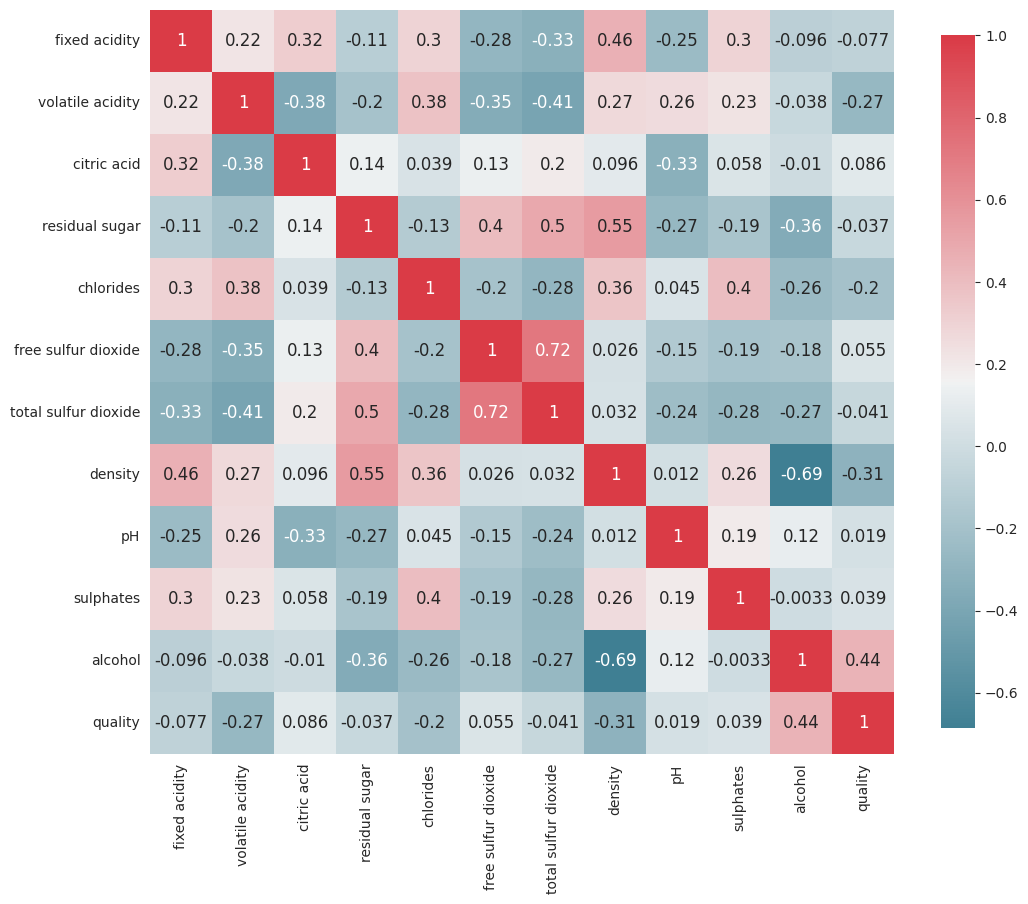

In [8]:
plot_correlation_map(df.iloc[0:,1:])

#### 2.4.3 Подробнее рассмотрим корреляцию между содержанием алкоголя и качеством вина

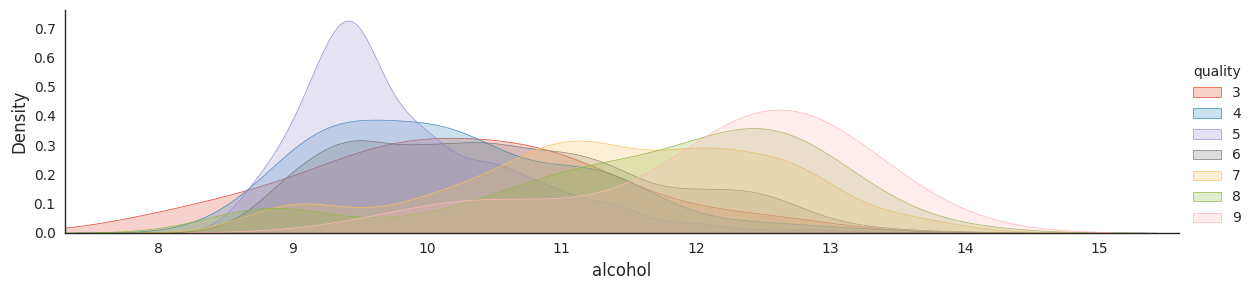

In [9]:
plot_distribution(df , var = 'alcohol' , target = 'quality')

График показывает зависимость качества вина от содержания алкоголя. Вершины куполов распределений вина лучшего качества смещены в сторону более высоких значений содержания алкоголя (прямая корреляция). Однако, четкого разделения нет и одни распределения перекрывают другие. Таким образом, корреляция есть, но она не настолько велика, чтобы можно было однозначно по уровню содержания алкоголя определить качество вина.

#### 2.4.4 Далее подробнее рассмотрим корреляцию между плотностью и качеством вина

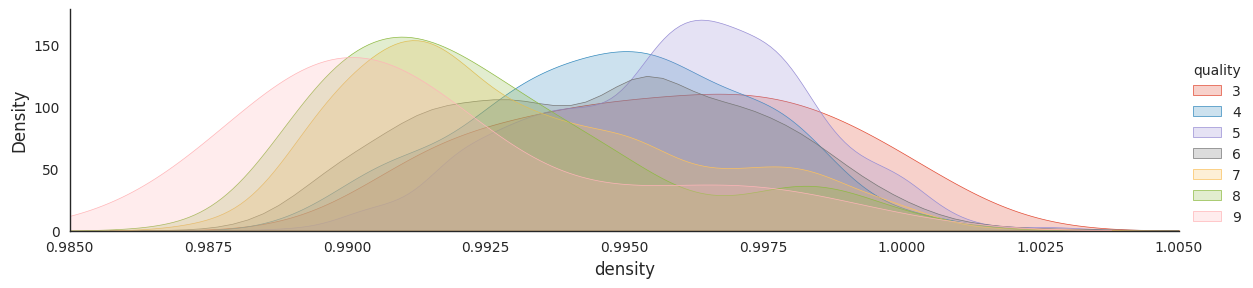

In [10]:
plot_distribution(df, var = 'density' , target = 'quality', xleft = 0.985, xright = 1.005)

Здесь ситуация обратная. Вершины распределений низкокачественных вин смещены в сторону большей плотности. В отличие от предыдущих рассматриваемых пар, тут общая площадь пересечений распределений еще выше, а, значит, еще сложнее, зная плотность, судить о качестве вина.

## 3. Data Preparation

#### 3.1 Категориальные переменные должны быть преобразованы в числовые переменные

Переменная type - категориальная. Некоторые из алгоритмов могут обрабатывать только числовые значения, поэтому нам нужно создать новую (фиктивную) переменную для каждого уникального значения категориальных переменных (OneHotEncoding)

In [11]:
df['type_oh'] = df['type'].replace(['white', 'red'], [0,1]) # преобразую тип вина
df.head()

,type,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality,type_oh
0,white,7.0,0.27,0.36,20.7,0.045,45.0,170.0,1.0010,3.00,0.45,8.8,6,0
1,white,6.3,0.30,0.34,1.6,0.049,14.0,132.0,0.9940,3.30,0.49,9.5,6,0
2,white,8.1,0.28,0.40,6.9,0.050,30.0,97.0,0.9951,3.26,0.44,10.1,6,0
3,white,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,6,0
4,white,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,6,0


#### 3.2 Заполнить пропущенные значения в переменных
Большинство алгоритмов машинного обучения требуют, чтобы все переменные имели значения, чтобы использовать их для обучения модели.
Ещё раз смотрю, есть ли пропуски.

In [12]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6497 entries, 0 to 6496
Data columns (total 14 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   type                  6497 non-null   object 
 1   fixed acidity         6487 non-null   float64
 2   volatile acidity      6489 non-null   float64
 3   citric acid           6494 non-null   float64
 4   residual sugar        6495 non-null   float64
 5   chlorides             6495 non-null   float64
 6   free sulfur dioxide   6497 non-null   float64
 7   total sulfur dioxide  6497 non-null   float64
 8   density               6497 non-null   float64
 9   pH                    6488 non-null   float64
 10  sulphates             6493 non-null   float64
 11  alcohol               6497 non-null   float64
 12  quality               6497 non-null   int64  
 13  type_oh               6497 non-null   int64  
dtypes: float64(11), int64(2), object(1)
memory usage: 710.7+ KB


Да, пропуски есть в полях: fixed acidity(10), volatile acidity(8), citric acid(3), residual sugar(2), chlorides(2), pH(9), sulphates(4). Их не много, но они в разных полях. Есть 2 простых варианта: отбросить строки с пропущенными значения или заменить на какое-то среднее. Поскольку пропуски вразных полях, то лучше не отбрасывать, т.к. если они не пересекаются по строкам, то мы можем потерять много строк. Поэтому заменим средними. Значения столбцов дробные, поэтому в качестве среднего выберем среднее арифметическое, т.к. для дробных это лучший вариант в сравнении с медианой и модой.

In [13]:
for column in ['fixed acidity', 'volatile acidity', 'citric acid', 'residual sugar', 'chlorides', 'pH', 'sulphates']:
    replace_nones(df, column)

df.to_csv("../data/intermid/wines_i.csv")
df.head()

,type,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality,type_oh
0,white,7.0,0.27,0.36,20.7,0.045,45.0,170.0,1.0010,3.00,0.45,8.8,6,0
1,white,6.3,0.30,0.34,1.6,0.049,14.0,132.0,0.9940,3.30,0.49,9.5,6,0
2,white,8.1,0.28,0.40,6.9,0.050,30.0,97.0,0.9951,3.26,0.44,10.1,6,0
3,white,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,6,0
4,white,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,6,0


## 3.3 Feature Engineering &ndash; добавляем новые признаки

Непосредственно из текущих данных нет возможности выделить дополнительные признаки. Если посмотреть на матрицу корреляций, то есть 2 пары наиболее скоррелированных признаков:  
1. "free sulfur dioxide" и "total sulfur dioxide" со значением 0,72;  
2. "density" и "alcohol" со значением -0,69.  

Степень корреляции в каждой паре довольно высокая, однако, недостаточная для исключения одного из пары.

## 3.4 Сборка финальных датасетов для моделирования

In [14]:
# features
df_features = df.drop(columns=['type', 'quality'])
df_features.to_csv('../data/processed/wines_features.csv')
df_features.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,type_oh
0,7.0,0.27,0.36,20.7,0.045,45.0,170.0,1.0010,3.00,0.45,8.8,0
1,6.3,0.30,0.34,1.6,0.049,14.0,132.0,0.9940,3.30,0.49,9.5,0
2,8.1,0.28,0.40,6.9,0.050,30.0,97.0,0.9951,3.26,0.44,10.1,0
3,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,0
4,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,0


In [15]:
df_target = df['quality']
df_target.to_csv('../data/processed/wines_target.csv')
df_target.head()

0    6
1    6
2    6
3    6
4    6
Name: quality, dtype: int64

#### 3.4.2 Нормализация

Чтобы качество модели было выше, данные предварительно нормализируем.

In [16]:
scaler = StandardScaler()
df_features_scaled = pd.DataFrame(scaler.fit_transform(df_features), columns=df_features.columns)
df_features_scaled.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,type_oh
0,-0.167159,-0.423564,0.284245,3.206977,-0.315222,0.815565,0.959976,2.102214,-1.359665,-0.545959,-1.418558,-0.571367
1,-0.707427,-0.241232,0.146523,-0.808136,-0.201027,-0.931107,0.287618,-0.232332,0.508045,-0.277064,-0.831615,-0.571367
2,0.681835,-0.362786,0.559689,0.306005,-0.172479,-0.029599,-0.331660,0.134525,0.259017,-0.613183,-0.328521,-0.571367
3,-0.012796,-0.666673,0.008801,0.642350,0.055911,0.928254,1.243074,0.301278,-0.176782,-0.882078,-0.496219,-0.571367
4,-0.012796,-0.666673,0.008801,0.642350,0.055911,0.928254,1.243074,0.301278,-0.176782,-0.882078,-0.496219,-0.571367


#### 3.4.3 Создание датасетов

Отделяем данные для обучения и для проверки

In [17]:
X_train, X_test, y_train, y_test = train_test_split(df_features_scaled, df_target, test_size = 0.3, random_state=100)

## 4. Моделирование
Теперь мы выберем модель, которую хотели бы попробовать. Используем обучающий набор данных для обучения модели и затем проверим ее с помощью тестового набора.

#### 4.1 Выбор модели
Для построения модели нам потребуется классификатор. Для простоты возьмем KNN-классификатор.

In [18]:
model = KNeighborsClassifier(df['quality'].max() - df['quality'].min() + 1)

## 4.2 Обучение и сохранение модели

In [19]:
model.fit(X_train , y_train)

pickle.dump(model, open('../models/knn_model', 'wb'))

## 5. Оценка
Теперь мы собираемся оценить модель

#### 5.1 Модель
Мы можем оценить точность модели, используя тестовый набор данных.

Затем мы сравниваем точность с точностью при использовании модели на тренировочных данных. Если результаты значительно отличаются, это свидетельствует о не очень высоком качестве модели.

In [20]:
print (f'train data: \t {model.score(X_train, y_train)} \n test_data: \t {model.score(X_test , y_test)}')

train data: 	 0.6705520123158126 
 test_data: 	 0.5635897435897436


## 6. Коррекция модели

#### 6.1 Выбор модели
Попробуем использовать другую модель - случайный лес.

In [21]:
model = RandomForestClassifier(max_depth=10, n_estimators=300, random_state=1000)

#### 6.2 Обучение и сохранение модели

In [22]:
model.fit(X_train , y_train)

pickle.dump(model, open('../models/random_forest', 'wb'))

## 7. Оценка скорректированной модели

#### 7.1 Модель

In [23]:
print (f'train data: \t {model.score(X_train, y_train)} \n test_data: \t {model.score(X_test , y_test)}')

train data: 	 0.8379151088629866 
 test_data: 	 0.6241025641025642


#### Качество на тренировочной выборке стало заметно выше, на тестовой тоже подносло, однако разрыв между ними увеличился, что может говорить о переобучении модели.

#### 7.2 Важность признаков
Оценим какие переменные являются наиболее важными для данной модели.

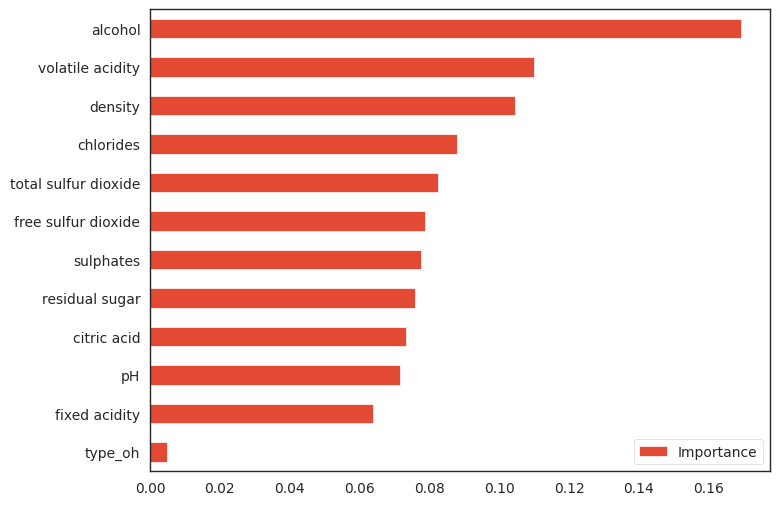

In [24]:
plot_model_var_imp(model, X_train, y_train, index=df_features.columns)

Значимость признаков оказалась довольно предсказуемой. На 1-ом месте самый скоррелированный с качеством вина признак - alcohol. На последнем - type, который по сути и не должен оказывать влияния на качество, т.к. было бы странно, если бы красное и белое вина одного производителя сильно отличались по качеству.

## 8. Развертывание

Развертывание в данном означает представление результата работы.

In [25]:
test_y = model.predict(X_test)
test = df.iloc[X_test.index]
test['quality_pred'] = test_y
test.to_csv("../data/output/wine_prediction.csv" , index = False)
test.head()

,type,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality,type_oh,quality_pred
5156,red,7.7,0.41,0.76,1.8,0.611,8.0,45.0,0.99680,3.06,1.26,9.4,5,1,5
4935,red,8.1,0.38,0.28,2.1,0.066,13.0,30.0,0.99680,3.23,0.73,9.7,7,1,6
2757,white,5.6,0.12,0.26,4.3,0.038,18.0,97.0,0.99477,3.36,0.46,9.2,5,0,6
3925,white,8.6,0.22,0.33,1.2,0.031,38.0,95.0,0.99239,2.83,0.31,10.3,5,0,6
2453,white,6.3,0.20,0.26,1.6,0.027,36.0,141.0,0.99268,3.53,0.56,10.8,6,0,7
